# Segmentation of Figure 8

In [1]:
import os
import numpy as np
import cv2
import pandas as pd
from skimage import io, color, filters, measure, morphology, segmentation
import matplotlib.pyplot as plt
import pytesseract
from pytesseract import Output
import warnings
warnings.filterwarnings('ignore')

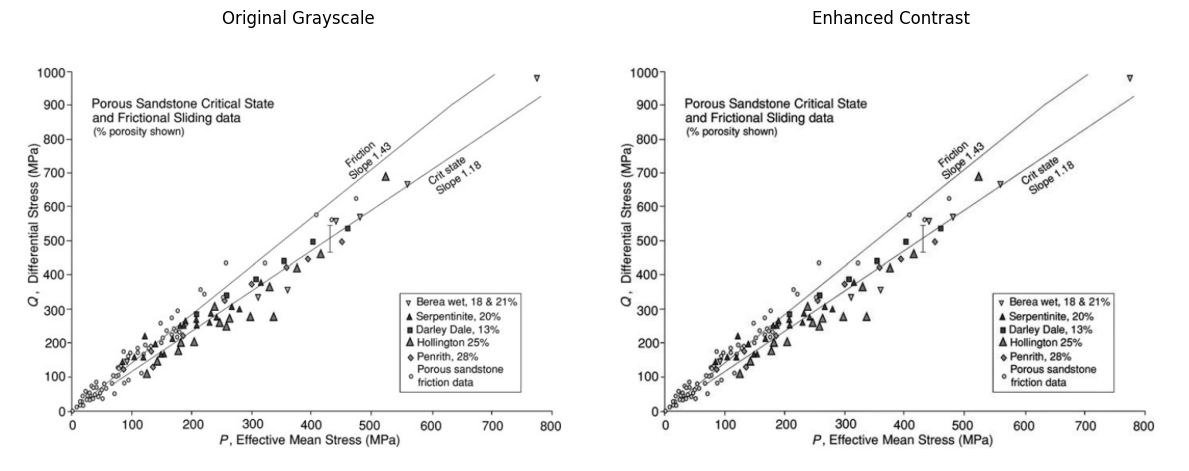

In [ ]:
# Load Figure 8 graph
image = cv2.imread('figure/fig8.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Enhance contrast using histogram equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
enhanced_grayscale = clahe.apply(grayscale_image)

# Display original and enhanced images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.imshow(grayscale_image, cmap='gray')
ax1.set_title('Original Grayscale')
ax1.axis('off')

ax2.imshow(enhanced_grayscale, cmap='gray')
ax2.set_title('Enhanced Contrast')
ax2.axis('off')

plt.tight_layout()
plt.show()

# Use the enhanced image for further processing
grayscale_image = enhanced_grayscale

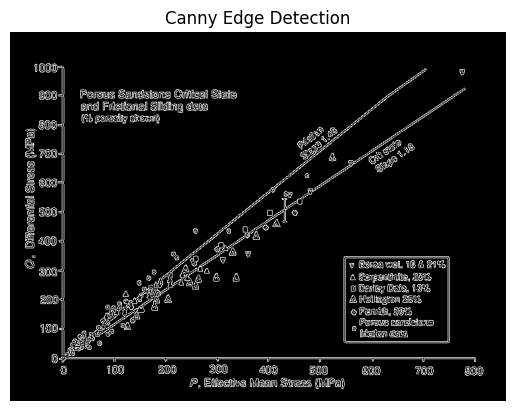

In [3]:
# Edge detection using Canny method
edges = cv2.Canny(grayscale_image, 100, 200)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.axis('off')
plt.show()

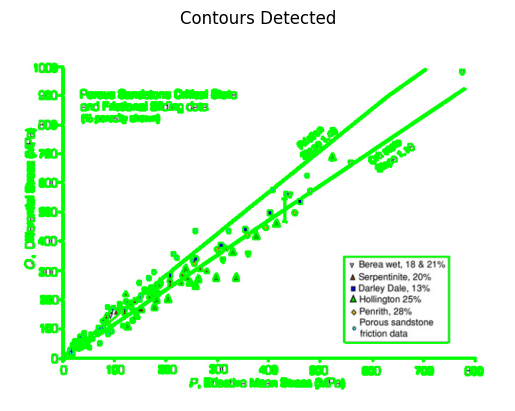

In [4]:
# Find contours in the image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Draw contours on the original image
contour_image = image.copy()
for contour in contours:
    cv2.drawContours(contour_image, [contour], -1, (0, 255, 0), 2)
plt.imshow(contour_image)
plt.title('Contours Detected')
plt.axis('off')
plt.show()

In [5]:
# Calculate areas of all contours
areas = [cv2.contourArea(c) for c in contours]
# print the areas of the contours
print(f"Number of contours: {len(areas)}")
print(f"Min area: {min(areas) if areas else 0}")
print(f"Max area: {max(areas) if areas else 0}")
print(f"Mean area: {np.mean(areas) if areas else 0}")
print(f"Median area: {np.median(areas) if areas else 0}")

Number of contours: 300
Min area: 0.0
Max area: 20663.5
Mean area: 108.54666666666667
Median area: 11.5


In [6]:
# Pair each contour with its area
contour_area_pairs = list(zip(contours, areas))
# Sort by area, descending
contour_area_pairs.sort(key=lambda x: x[1], reverse=True)

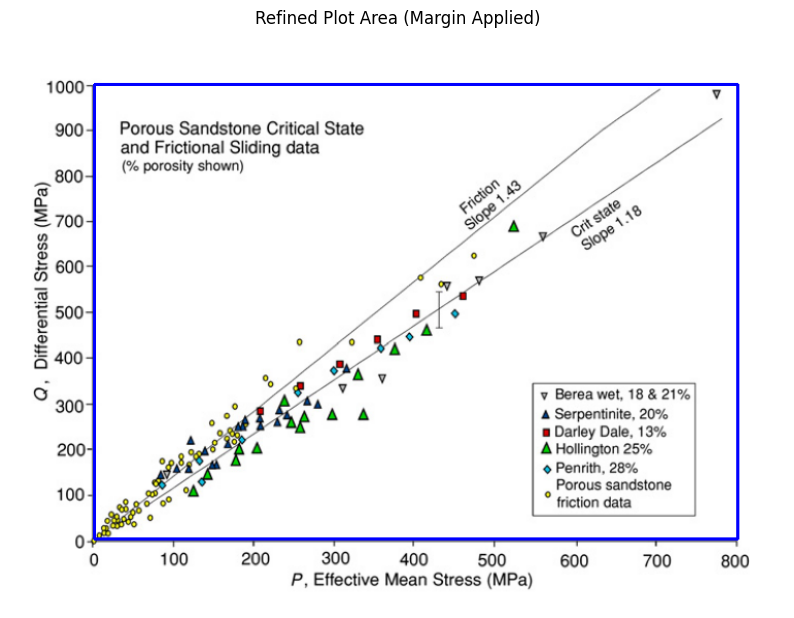

In [7]:
# Identifying the Plot Area
# Use Canny edge detection
edges = cv2.Canny(grayscale_image, 50, 150)

margin = 15  # You can adjust this value as needed

# Use Hough Line Transform to detect lines
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

# Find the extreme lines (leftmost, rightmost, topmost, bottommost)
x_min, x_max, y_min, y_max = image.shape[1], 0, image.shape[0], 0
for line in lines:
    x1, y1, x2, y2 = line[0]
    x_min = min(x_min, x1, x2)
    x_max = max(x_max, x1, x2)
    y_min = min(y_min, y1, y2)
    y_max = max(y_max, y1, y2)

# Refine the bounding box: move left and bottom sides inward by margin
plot_left   = min(x_min + margin + 3, image.shape[1] - 1)
plot_right  = max(x_max, 0)
plot_top    = min(y_min, image.shape[0] - 1)
plot_bottom = max(y_max - margin - 30, 0)

# Ensure coordinates are within image bounds
plot_left   = max(plot_left, 0)
plot_right  = min(plot_right, image.shape[1] - 1)
plot_top    = max(plot_top, 0)
plot_bottom = min(plot_bottom, image.shape[0] - 1)

# Draw the refined plot area
plot_area_img = image.copy()
cv2.rectangle(plot_area_img, (plot_left, plot_top), (plot_right, plot_bottom), (255, 0, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(plot_area_img, cv2.COLOR_BGR2RGB))
plt.title('Refined Plot Area (Margin Applied)')
plt.axis('off')
plt.show()

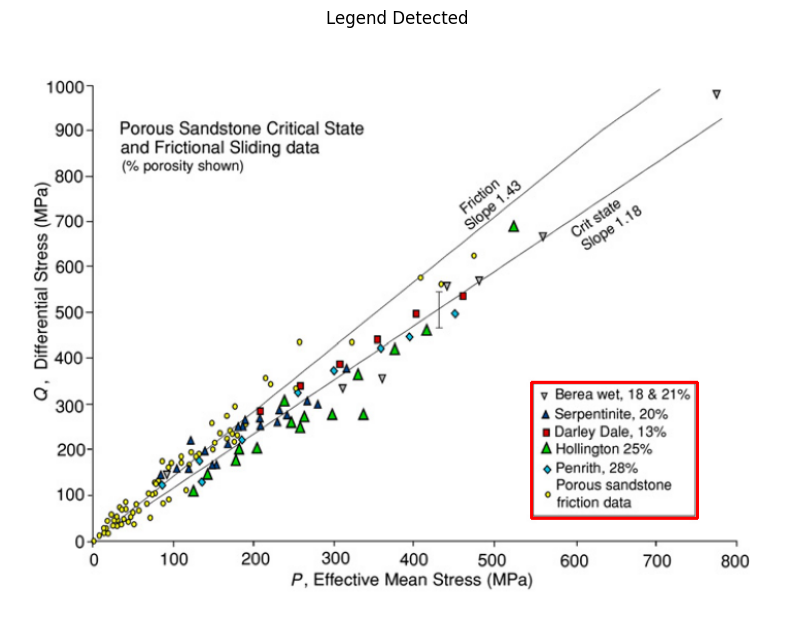

In [8]:
# Identifying the Legend Area
legend_candidates = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    area = w * h
    aspect_ratio = w / h if h != 0 else 0
    # Heuristic: legend is in the right 1/3 and lower 1/2 of the image, and is a medium-large box
    if (x > image.shape[1] * 0.6 and y > image.shape[0] * 0.5 and
        area > 1000 and area < 0.2 * image.shape[0] * image.shape[1] and
        0.7 < aspect_ratio < 2.5):
        legend_candidates.append((x, y, w, h))

# Draw the legend box
legend_img = image.copy()
for (x, y, w, h) in legend_candidates:
    cv2.rectangle(legend_img, (x, y), (x + w, y + h), (0, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(legend_img, cv2.COLOR_BGR2RGB))
plt.title('Legend Detected')
plt.axis('off')
plt.show()

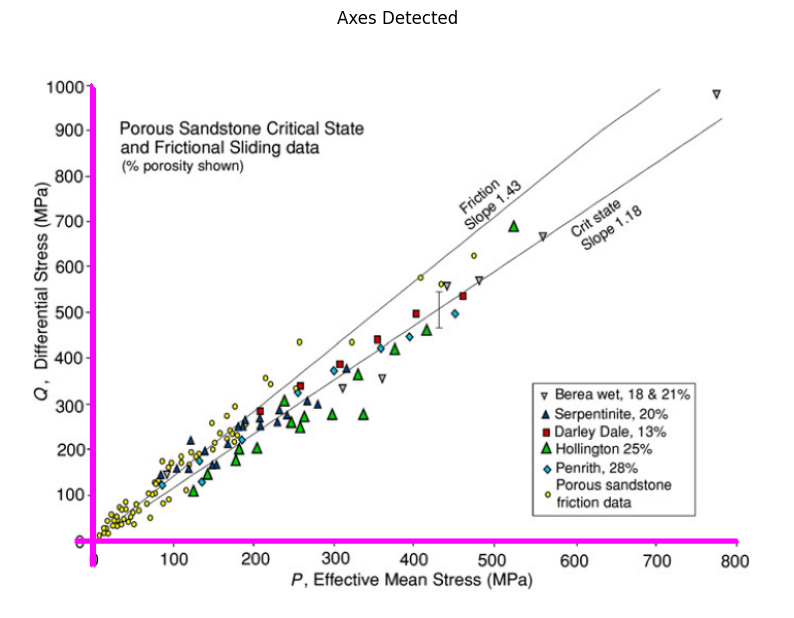

In [9]:
# Identifying the Axes
axes_img = image.copy()
for line in lines:
    x1, y1, x2, y2 = line[0]
    # Vertical (y-axis)
    if abs(x1 - x2) < 10 and abs(y1 - y2) > image.shape[0] * 0.7:
        cv2.line(axes_img, (x1, y1), (x2, y2), (255, 0, 255), 2)
    # Horizontal (x-axis)
    if abs(y1 - y2) < 10 and abs(x1 - x2) > image.shape[1] * 0.7:
        cv2.line(axes_img, (x1, y1), (x2, y2), (255, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(axes_img, cv2.COLOR_BGR2RGB))
plt.title('Axes Detected')
plt.axis('off')
plt.show()

## Extract Text from Plot Regions
Extract text from title, legend, and axes scales & labels using OCR

## Extract Axes Information
Extract scales and titles from the detected axes regions

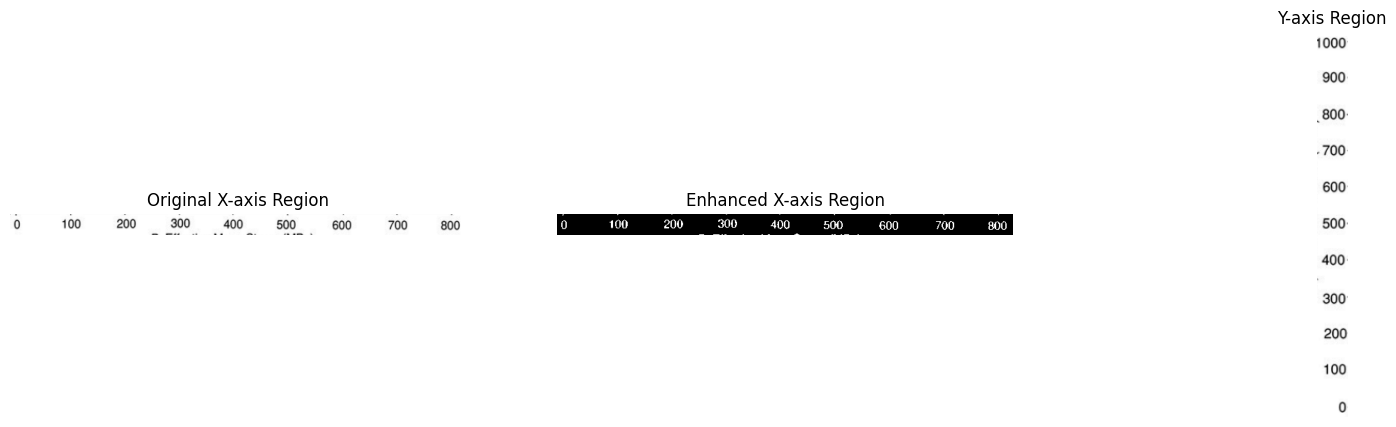

In [10]:
# Extract x-axis scale region with adjusted boundaries
x_scale_region = grayscale_image[plot_bottom+5:plot_bottom+35, plot_left-10:plot_right+20]

# Enhance x-axis scale visibility
x_scale_enhanced = cv2.threshold(
    x_scale_region,
    127, 255,
    cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
)[1]

# Dilate text slightly to separate digits
kernel = np.ones((2,1), np.uint8)
x_scale_enhanced = cv2.erode(x_scale_enhanced, kernel, iterations=1)

# Extract y-axis scale region with adjusted boundaries
y_scale_region = grayscale_image[plot_top-10:plot_bottom+15, max(0, plot_left-44):plot_left-7]

# Visualize the extracted and preprocessed regions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.imshow(x_scale_region, cmap='gray')
ax1.set_title('Original X-axis Region')
ax1.axis('off')

ax2.imshow(x_scale_enhanced, cmap='gray')
ax2.set_title('Enhanced X-axis Region')
ax2.axis('off')

ax3.imshow(y_scale_region, cmap='gray')
ax3.set_title('Y-axis Region')
ax3.axis('off')
plt.show()

In [11]:
def process_x_axis_text(text):
    # Clean up the text
    text = text.replace('\n', ' ').strip()

    # If we have a long string of digits, try to segment it
    if len(text) > 10 and text.isdigit():
        # Try to segment based on expected values (0,100,200,300,etc)
        expected_values = [0, 100, 200, 300, 400, 500, 600, 700, 800]
        values = []

        # Try different segmentation approaches
        for segment_length in [1, 2, 3, 4]:
            potential_values = []
            for i in range(0, len(text), segment_length):
                if i + segment_length <= len(text):
                    segment = text[i:i+segment_length]
                    try:
                        value = int(segment)
                        potential_values.append(value)
                    except ValueError:
                        continue

            # Check if this segmentation gives expected values
            if any(expected in potential_values for expected in expected_values):
                values = potential_values
                break

        return sorted(list(set(values)))

    # Original approach as fallback
    import re
    numbers = re.findall(r'\d+', text)
    values = []
    expected_values = [0, 100, 200, 300, 400, 500, 600, 700, 800]

    for num in numbers:
        try:
            value = int(num)
            if any(abs(value - expected) < 50 for expected in expected_values):
                values.append(value)
        except ValueError:
            continue

    return sorted(list(set(values)))

# Extract text from scale regions with specific OCR configuration
x_scale_text = pytesseract.image_to_string(
    x_scale_enhanced,  # Use the enhanced image
    config='--psm 11 --oem 3 -c tessedit_char_whitelist=0123456789 -c tessedit_char_blacklist=.,- -c preserve_interword_spaces=1'
)

y_scale_text = pytesseract.image_to_string(
    y_scale_region,
    config='--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789.-'
)

# Process the text to extract values
x_values = process_x_axis_text(x_scale_text)
y_values = sorted([int(n) for n in y_scale_text.split() if n.strip()], reverse=True)

print('X-axis values:', x_values)
print('Y-axis values:', y_values)

X-axis values: [0, 100, 200, 300, 400, 500, 600, 700, 800]
Y-axis values: [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 0]


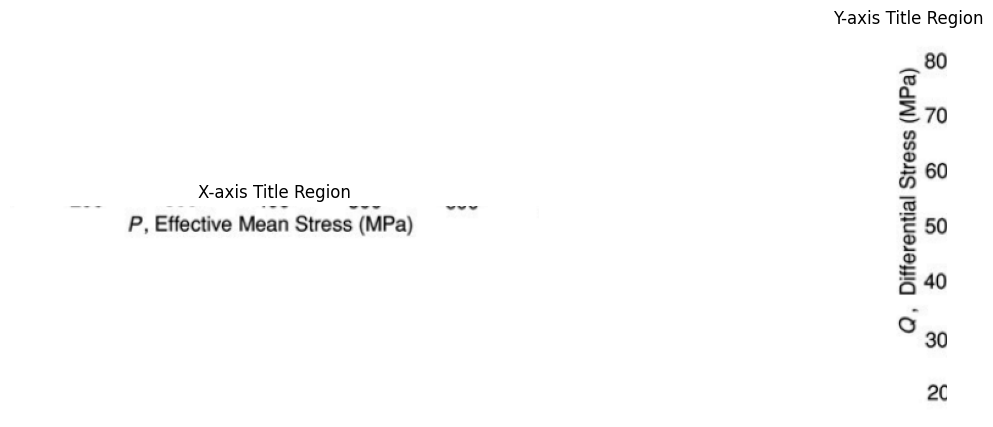

X-axis title: ___ P, Effective Mean Stress (MPa)
Y-axis title: ~ s Citororal Skoss wre)


In [12]:
# Extract a more precise region for the x-axis title
# The title appears to be centered below the x-axis scale
x_center = (plot_left + plot_right) // 2
x_title_width = int((plot_right - plot_left) * 0.7)  # Take 70% of plot width
x_title_region = grayscale_image[plot_bottom+25:plot_bottom+55,
                                x_center - x_title_width//2:x_center + x_title_width//2]

# For y-axis title, extract a taller, narrower region
# The title appears to be centered to the left of the y-axis scale
y_center = (plot_top + plot_bottom) // 2
y_title_height = int((plot_bottom - plot_top) * 0.7)  # Take 70% of plot height
y_title_region = grayscale_image[y_center - y_title_height//2:y_center + y_title_height//2,
                                max(0, plot_left-80):max(0, plot_left-20)]

# Visualize the extracted regions to verify they capture the titles correctly
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(x_title_region, cmap='gray')
ax1.set_title('X-axis Title Region')
ax1.axis('off')

ax2.imshow(y_title_region, cmap='gray')
ax2.set_title('Y-axis Title Region')
ax2.axis('off')
plt.show()

# Apply simple preprocessing
x_title_enhanced = cv2.threshold(x_title_region, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
y_title_enhanced = cv2.threshold(y_title_region, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# OCR with appropriate configuration
x_title = pytesseract.image_to_string(
    x_title_enhanced,
    config='--psm 7 -l eng'  # Single line of text
).strip()

# For y-axis, rotate the image 90 degrees clockwise
y_title_rotated = cv2.rotate(y_title_enhanced, cv2.ROTATE_90_CLOCKWISE)
y_title = pytesseract.image_to_string(
    y_title_rotated,
    config='--psm 7 -l eng'  # Single line of text
).strip()

print('X-axis title:', x_title)
print('Y-axis title:', y_title)

In [13]:
# X-axis title region is good, just needs minor adjustment
x_title_region = grayscale_image[plot_bottom+25:plot_bottom+55,
                                x_center - x_title_width//2:x_center + x_title_width//2]

# For y-axis, try a different approach - extract a wider region
y_title_region = grayscale_image[y_center - y_title_height//2:y_center + y_title_height//2,
                                max(0, plot_left-100):plot_left]

# Apply better preprocessing for y-axis
# 1. Resize to larger dimensions
y_title_large = cv2.resize(y_title_region, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)

# 2. Apply adaptive thresholding
y_title_enhanced = cv2.adaptiveThreshold(
    y_title_large, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 11, 2)

# OCR for x-axis (already working well)
x_title = pytesseract.image_to_string(
    x_title_enhanced,
    config='--psm 7 -l eng'
).strip().replace('___', '').strip()

# Extract y-axis title region
y_title_region = grayscale_image[plot_top:plot_bottom, max(0, plot_left-120):max(0, plot_left-10)]

# Basic preprocessing - resize and binarize
y_title_large = cv2.resize(y_title_region, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)
_, y_title_binary = cv2.threshold(y_title_large, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Rotate and apply OCR with the optimal configuration
y_title_rotated = cv2.rotate(y_title_binary, cv2.ROTATE_90_CLOCKWISE)
y_title = pytesseract.image_to_string(
    y_title_rotated,
    config='--psm 11 --oem 3 -l eng'
).strip()

# If we get multiple lines, take just the first line (the title)
y_title = y_title.split('\n')[0] if '\n' in y_title else y_title

print('X-axis title:', x_title)
print('Y-axis title:', y_title)

X-axis title: P, Effective Mean Stress (MPa)
Y-axis title: Q, Differential Stress (MPa)


## Plot title extraction

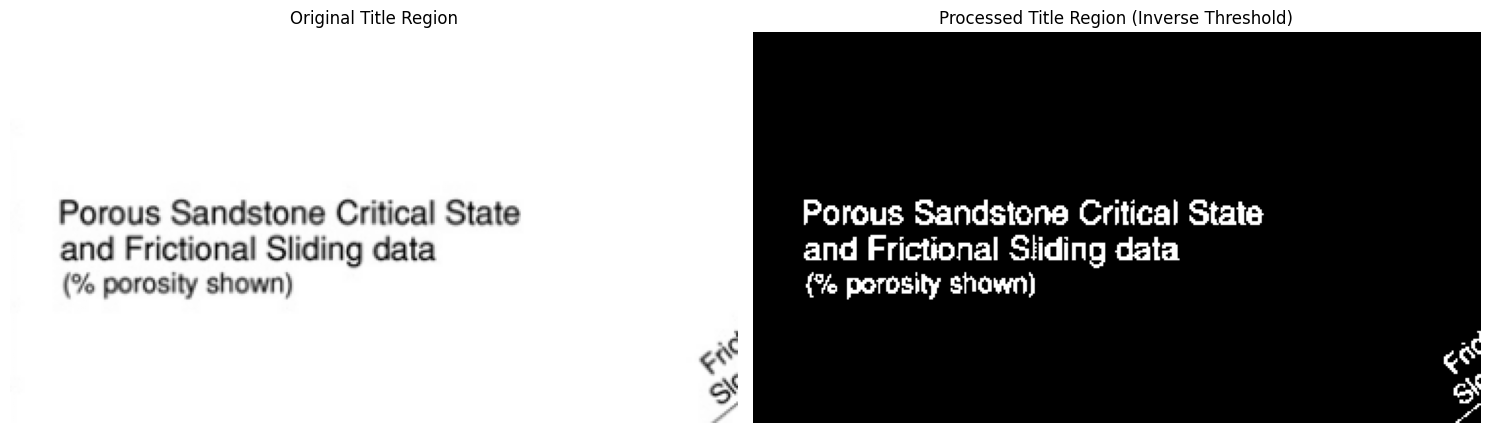

Plot title:
Porous Sandstone Critical State
and Frictional Sliding data
(% porosity shawn)


In [14]:
# Convert to grayscale if needed
if len(image.shape) == 3:
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
else:
    grayscale_image = image

# Focus on the top-left region with appropriate dimensions for this multi-line title
top_left_region = grayscale_image[max(0, plot_top-50):plot_top+150,
                                 plot_left:plot_left+int((plot_right-plot_left)*0.6)]

# Apply inverse thresholding (which worked best)
_, binary_inverse = cv2.threshold(top_left_region, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Visualize the region and preprocessing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.imshow(top_left_region, cmap='gray')
ax1.set_title('Original Title Region')
ax1.axis('off')

ax2.imshow(binary_inverse, cmap='gray')
ax2.set_title('Processed Title Region (Inverse Threshold)')
ax2.axis('off')

plt.tight_layout()
plt.show()

# Extract text using OCR with PSM 3 (which worked best for multi-line text)
plot_title = pytesseract.image_to_string(
    binary_inverse,
    config='--psm 3 -l eng'
).strip()

# Clean up any remaining artifacts
plot_title = plot_title.replace('«', '').replace('ss', '').strip()

print('Plot title:')
print(plot_title)

## Extracting Data Points

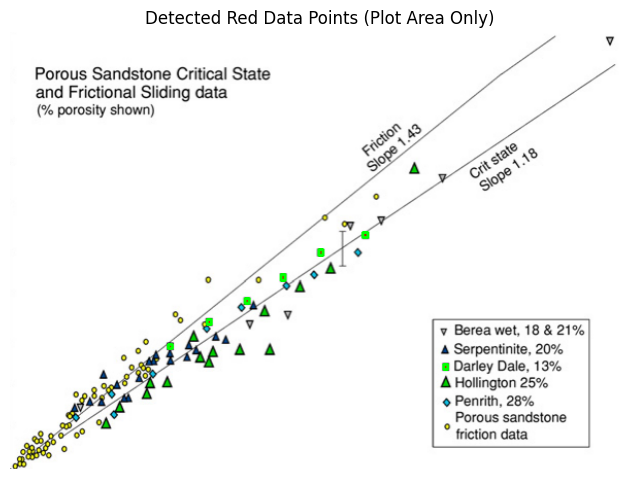

Centroids (plot-area coordinates): [(436, 335), (160, 315), (199, 290), (236, 269), (272, 246), (310, 221), (355, 203)]


In [18]:
# --- After plot area detection ---

# Crop the plot area for all further processing
plot_area = image[plot_top:plot_bottom, plot_left:plot_right]
plot_area_rgb = cv2.cvtColor(plot_area, cv2.COLOR_BGR2RGB)
plot_area_gray = cv2.cvtColor(plot_area, cv2.COLOR_BGR2GRAY)

# Enhance contrast in the cropped area
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced_gray = clahe.apply(plot_area_gray)

# Convert to HSV for color segmentation
hsv = cv2.cvtColor(plot_area_rgb, cv2.COLOR_RGB2HSV)

# Example: segment red points (repeat for other colors)
lower_red1 = np.array([0, 70, 50])
upper_red1 = np.array([10, 255, 255])
mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
lower_red2 = np.array([170, 70, 50])
upper_red2 = np.array([180, 255, 255])
mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)
red_mask = cv2.bitwise_or(mask_red1, mask_red2)

# Remove small noise (morphological opening)
kernel = np.ones((3,3), np.uint8)
red_mask_clean = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel, iterations=1)

# Find contours in the mask
contours, _ = cv2.findContours(red_mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter by area to avoid noise
min_area = 10  # Tune as needed
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

# Draw detected points on the cropped plot area
output = plot_area_rgb.copy()
cv2.drawContours(output, filtered_contours, -1, (0,255,0), 2)

plt.figure(figsize=(8, 8))
plt.imshow(output)
plt.title('Detected Red Data Points (Plot Area Only)')
plt.axis('off')
plt.show()

# Extract centroids (in plot-area coordinates)
centroids = []
for cnt in filtered_contours:
    M = cv2.moments(cnt)
    if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        centroids.append((cx, cy))

print("Centroids (plot-area coordinates):", centroids)